In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# Define the ticker symbol and time period
ticker_symbol = 'AZN.L'
start_date = '2015-01-01'
end_date = '2024-06-01'

# Fetch historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,4552.0,4616.0,4546.680176,4580.0,3317.049561,1367467
2015-01-05,4573.0,4620.0,4563.500000,4583.5,3319.584229,3574018
2015-01-06,4572.0,4583.5,4488.500000,4488.5,3250.780762,2303838
2015-01-07,4517.5,4526.0,4469.500000,4479.5,3244.263184,3312015
2015-01-08,4513.0,4585.5,4500.000000,4572.5,3311.617920,2721743


In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-24,12334.0,12442.0,12244.000000,12296.0,12296.0,919468
2024-05-28,12226.0,12266.0,11988.000000,12028.0,12028.0,2196897
2024-05-29,12052.0,12094.0,11879.241211,11930.0,11930.0,2028914
2024-05-30,12108.0,12188.0,11858.000000,12028.0,12028.0,1694793
2024-05-31,12036.0,12214.0,11954.000000,12190.0,12190.0,4183291


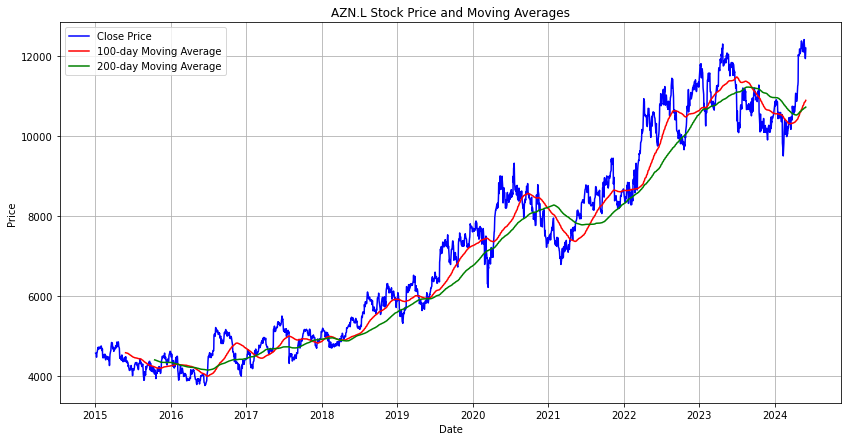

In [5]:
# Calculate 100-day and 200-day moving averages
data['MA_100'] = data['Close'].rolling(window=100).mean()
data['MA_200'] = data['Close'].rolling(window=200).mean()
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA_100'], label='100-day Moving Average', color='red')
plt.plot(data['MA_200'], label='200-day Moving Average', color='green')

plt.title(f'{ticker_symbol} Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
data.shape

(2377, 8)

In [7]:
data_training = pd.DataFrame(data['Close'][0:int(len(data)*0.70)])
data_testing = pd.DataFrame(data['Close'][int(len(data)*0.70): int(len(data))])

In [8]:
data_training

,Close
Date,
2015-01-02,4580.0
2015-01-05,4583.5
2015-01-06,4488.5
2015-01-07,4479.5
2015-01-08,4572.5
...,...
2021-07-23,8480.0
2021-07-26,8292.0
2021-07-27,8253.0


In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)
data_training_array.shape

(1663, 1)

In [10]:
X_train = []
y_train = []

for i in range(100, data_training_array.shape[0]): # Setting window size for prediction as 100
    X_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM Model

In [11]:
model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Anish\Anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 0.0919
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0112
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0088
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0082
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0086
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0078
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0069
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0061
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0061
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0062
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0059
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0057
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0058
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0049
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0058
Epoc

In [17]:
data_testing.head()

,Close
Date,
2021-07-30,8268.0
2021-08-02,8274.0
2021-08-03,8297.0
2021-08-04,8270.0
2021-08-05,8342.0


In [19]:
past_100_days = data_training.tail(100)

In [20]:
final_df = past_100_days.append(data_testing,ignore_index = False)

C:\Users\Anish\AppData\Local\Temp/ipykernel_12540/3059208055.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(data_testing,ignore_index = False)


In [21]:
final_df.head()

,Close
Date,
2021-03-08,7005.0
2021-03-09,7131.0
2021-03-10,7192.0
2021-03-11,7011.0
2021-03-12,6951.0


In [22]:
input_data = scaler.fit_transform(final_df)
input_data.shape

(814, 1)

In [23]:
X_test = []
y_test = []

for i in range(100,input_data.shape[0]):
    X_test.append(input_data[i-100 : i])
    y_test.append(input_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(714, 100, 1)
(714,)


In [24]:
#Predictions

y_predicted = model.predict(X_test)
y_predicted.shape

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


(714, 1)

In [25]:
scaler.scale_

array([0.00018339])

In [26]:
scale_factor = 1/(0.00031827)

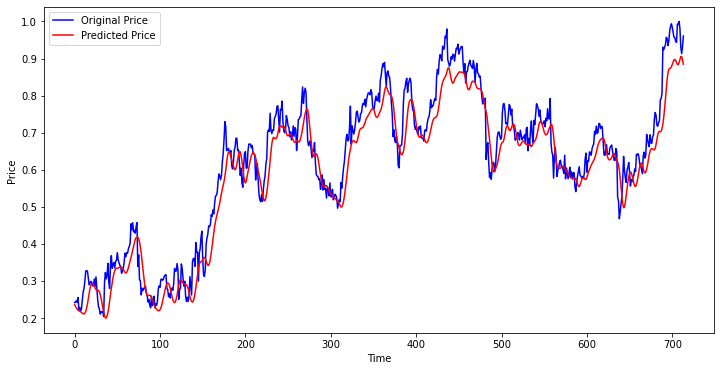

In [27]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label = 'Original Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluation

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
r2_score = r2_score(y_test, y_predicted)
print(r2_score)
mae = mean_absolute_error(y_test, y_predicted)
print(mae)

0.9171554094052169
0.04519800596799493
